# Tutorial 3: Tensor Parallel and Transformers Scaling

[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-181717?style=flat-square&logo=github)](https://github.com/sshkhr/MinText/blob/main/docs/tutorials/3_Tensor_Parallel_and_Transformers.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sshkhr/MinText/blob/main/docs/tutorials/3_Tensor_Parallel_and_Transformers.ipynb)

In the previous tutorial, we learned about data parallelism and how to use it to shard data batches across devices. We also learned about Fully Sharded Data Parallel (FSDP) and how it can be used to shard model parameters, gradients and optimizer states across devices. In this part, we will cover tensor parallelism and how it can be used to shard model layers across devices. We will also learn how to use the different parallelism techniques together to scale up training of an actual transformer model.

## 0. Setup

Let's start by importing the necessary libraries and initializing our environment.

In [1]:
import os
# Force JAX to see 8 devices for this tutorial (only use if not using TPU runtime)
#os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
from jax.experimental import mesh_utils
from flax import nnx
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
import dataclasses

import optax

In [2]:
# Check available devices
print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()[:4]}...")
print(f"Number of devices: {jax.device_count()}")

JAX version: 0.5.2
Available devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1)]...
Number of devices: 8


In [3]:
# Requirements for Language Modelling
!pip install -Uq tiktoken grain matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.5/485.5 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 6.4 MB/s eta 0:00:00


## 1. Tensor Parallelism

While fully-sharded data parallelism distributes model weights across different devices during the AllReduce operation, tensor parallelism takes a different approach. Also known as "1D model parallelism" or Megatron sharding, this technique shards the feedforward dimensions of individual model layers and distributes activations between devices during computation. This method enables smaller effective batch sizes per device, making it particularly useful for training very large models. The diagram below illustrates how a single matrix is partitioned across devices using this approach:

### 1.1 Tensor Parallelism Theory

**Sharding**: Model layer activations are sharded along tensor axes across devices, model parameters are replicated on each device.

**Equation** (for our MLP example):
$$\text{In}[B, D_Y] \cdot_D W_\text{in}[D, F_Y] \cdot_F W_\text{out}[F_Y, D] \rightarrow \text{Out}[B, D_Y]$$

where $F_Y$ indicates the activations are sharded across $Y$ devices.

![Tensor Parallel](https://jax-ml.github.io/scaling-book/assets/img/model-parallelism-1400.webp)

<sup> Image Source: [How To Scale Your Model](https://jax-ml.github.io/scaling-book) </sup>

### 1.2 Tensor Parallelism Algorithm

The computation pattern In[B, D_Y] * W_in[D, F_Y] * W_out[F_Y, D] → Out[B, D_Y] requires gathering activations prior to the initial matrix multiplication. This approach becomes more efficient than ZeRO sharding when activation sizes are smaller than weight sizes.

**Forward pass:** need to compute Loss[B]

1.  In[B, D] = **AllGather**(In[B, D<sub>Y</sub>]) *(on critical path)*
2.  Tmp[B, F<sub>Y</sub>] = In[B, D] \*<sub>D</sub> W<sub>in</sub>[D, F<sub>Y</sub>] *(not sharded along contracting, so no comms)*
3.  Out[B, D] {U<sub>Y</sub>} = Tmp[B, F<sub>Y</sub>] \*<sub>F</sub> W<sub>out</sub>[F<sub>Y</sub>, D]
4.  Out[B, D<sub>Y</sub>] = **ReduceScatter**(Out[B, D] {U<sub>Y</sub>}) *(on critical path)*
5.  Loss[B] = ...

**Backward pass:** need to compute dW<sub>out</sub>[F<sub>Y</sub>, D], dW<sub>in</sub>[D, F<sub>Y</sub>]

1.  dOut[B, D<sub>Y</sub>] = ...
2.  dOut[B, D] = **AllGather**(dOut[B, D<sub>Y</sub>]) *(on critical path)*
3.  dW<sub>out</sub>[F<sub>Y</sub>, D] = Tmp[B, F<sub>Y</sub>] \*<sub>B</sub> dOut[B, D]
4.  dTmp[B, F<sub>Y</sub>] = dOut[B, D] \*<sub>D</sub> W<sub>out</sub>[F<sub>Y</sub>, D] *(can throw away dOut[B, D] here)*
5.  In[B, D] = **AllGather**(In[B, D<sub>Y</sub>]) *(this can be skipped by sharing with (1) from the forward pass)*
6.  dW<sub>in</sub>[D, F<sub>Y</sub>] = dTmp[B, F<sub>Y</sub>] \*<sub>B</sub> In[B, D]
7.  dIn[B, D] {U.Y} = dTmp[B, F<sub>Y</sub>] \*<sub>F</sub> W<sub>in</sub>[D, F<sub>Y</sub>] *(needed for previous layers)*
8.  dIn[B, D<sub>Y</sub>] = **ReduceScatter**(dIn[B, D] {U.Y}) *(on critical path)*

A key advantage of the two matrix operations in our MLP forward pass is that tensor parallelism integrates nicely with this setup. Without this optimization, we would need to perform an AllReduce operation after each matrix multiplication. However, the sequential computation In[B, D_Y] * W_in[D, F_Y] → Tmp[B, F_Y] followed by Tmp[B, F_Y] * W_out[F_Y, D] → Out[B, D_Y] allows us to perform a single AllGather on the input at the start and a single ReduceScatter on the output at the end, eliminating the need for intermediate AllReduce operations.

## 2. Combining Parallelism Techniques

In this section, we will combine FSDP, and tensor parallelism to implemnt distributed training of a simple MLP model. The efficiency from gathering activations prior to matrix multiplyin tensor parallelism typically emerges only when combined with some degree of ZeRO sharding, which reduces the gather operation's overhead. This synergy explains why ZeRO sharding and model parallelism are commonly used together in practice.


### 2.1 Mesh Definition

In [4]:
# Assign logical names 'data' and 'model' to the axes of this grid.
# The first dimension (size 2) is named 'data'.
# The second dimension (size 4) is named 'model'.
mesh = jax.sharding.Mesh(
  mesh_utils.create_device_mesh((2, 4)),
  ('data', 'model'),
)

### 2.2 Sharding Helper Functions

In [5]:
# A helper function to quickly create a NamedSharding object
# using the globally defined 'mesh'.
def named_sharding(*names: str | None) -> NamedSharding:
  # P(*names) creates a PartitionSpec, e.g., P('data', None)
  # NamedSharding binds this PartitionSpec to the 'mesh'.
  return NamedSharding(mesh, P(*names))


@dataclasses.dataclass(unsafe_hash=True)
class MeshRules:
  """Rules for combined FSDP (data parallel) + tensor parallel sharding"""
  weight_0: str | None = None     # First dimension of weights
  weight_1: str | None = 'model'  # Second dimension of weights (tensor parallel)
  bias: str | None = 'model'      # Bias sharded along model axis
  data: str | None = 'data'       # Data sharded along data axis

  def __call__(self, *keys: str) -> tuple[str, ...]:
    return tuple(getattr(self, key) for key in keys)

mesh_rules = MeshRules()

### 2.3 Define The Sharded Model

In [6]:
# Modified MLP using nnx.Linear with tensor parallelism
class MLP(nnx.Module):
  def __init__(self, din, dmid, dout, *, rngs: nnx.Rngs):
    # For linear1: (128, 2048) -> shard second dimension
    self.linear1 = nnx.Linear(
        din, dmid,
        kernel_init=nnx.with_metadata(
            nnx.initializers.lecun_normal(),
            sharding=mesh_rules('weight_0', 'weight_1')  # (None, 'model')
        ),
        bias_init=nnx.with_metadata(
            nnx.initializers.zeros_init(),
            sharding=mesh_rules('bias')  # ('model',)
        ),
        rngs=rngs
    )

    # For linear2: (2048, 128) -> shard first dimension
    self.linear2 = nnx.Linear(
        dmid, dout,
        kernel_init=nnx.with_metadata(
            nnx.initializers.lecun_normal(),
            sharding=('model', None)  # Custom sharding for this layer
        ),
        bias_init=nnx.with_metadata(
            nnx.initializers.zeros_init(),
            sharding=(None,)  # Don't shard output bias
        ),
        rngs=rngs
    )

  def __call__(self, x):
    x = nnx.relu(self.linear1(x))
    return self.linear2(x)

### 2.4 Handling Sharded Optimizer State

In [7]:
# Define a custom type for SGD momentum state, inheriting from nnx.Variable.
# This allows it to be tracked as part of the NNX state tree.
class SGDState(nnx.Variable):
  pass

# Define the SGD optimizer using NNX API.
class SGD(nnx.Object):
  # Constructor takes the model parameters (as nnx.State), learning rate, and decay.
  def __init__(self, params: nnx.State, lr, decay=0.9):
    # Helper function to initialize momentum buffer for a given parameter.
    def init_optimizer_state(variable: nnx.Variable):
      # Create momentum state with zeros, same shape and metadata (incl. sharding)
      # as the parameter it corresponds to.
      return SGDState(
        jnp.zeros_like(variable.value), **variable.get_metadata()
      )

    self.lr = lr
    # Store a reference to the parameter State tree.
    self.params = params
    # Create the momentum state tree, mirroring the structure of 'params',
    # using the helper function. Momentum will have the same sharding as params.
    self.momentum = jax.tree.map(init_optimizer_state, self.params)
    self.decay = decay

  # Method to update parameters based on gradients.
  def update(self, grads: nnx.State):
    # Define the update logic for a single parameter/momentum/gradient triple.
    def update_fn(
      params: nnx.Variable, momentum: SGDState, grad: nnx.VariableState
    ):
      # Standard SGD with momentum update rule.
      # v_t = β * v_{t-1} + (1 - β) * ∇J(θ_t)
      momentum.value = self.decay * momentum.value + (1 - self.decay) * grad.value
      # θ_{t+1} = θ_t - α * v_t
      params.value -= self.lr * momentum.value # NOTE: Direct mutation of param value!

    # Apply the update function across the parameter, momentum, and gradient trees.
    # This performs the update in-place on the parameter values referenced by self.params.
    jax.tree.map(update_fn, self.params, self.momentum, grads)


### 2.5 Applying Sharding to the Model and Optimizer

In [8]:
@nnx.jit
def create_model():
  model = MLP(128, 2048, 128, rngs=nnx.Rngs(0))
  optimizer = SGD(nnx.variables(model, nnx.Param), 0.01, decay=0.9)

  # Extract state
  state = nnx.state(optimizer)

  # Define sharding for the state pytree
  def get_named_shardings(path: tuple, value: nnx.VariableState):
    if path[0] == 'params':
      return value.replace(NamedSharding(mesh, P(*value.sharding)))
    elif path[0] == 'momentum':
      return value.replace(NamedSharding(mesh, P(*value.sharding)))
    else:
      raise ValueError(f'Unknown path: {path}')

  named_shardings = state.map(get_named_shardings)
  sharded_state = jax.lax.with_sharding_constraint(state, named_shardings)
  nnx.update(optimizer, sharded_state)

  return model, optimizer

model, optimizer = create_model()

# Visualize sharding
print("Linear1 kernel sharding (128, 2048):")
jax.debug.visualize_array_sharding(model.linear1.kernel.value)
print("\nLinear2 kernel sharding (2048, 128):")
jax.debug.visualize_array_sharding(model.linear2.kernel.value)

Linear1 kernel sharding (128, 2048):



Linear2 kernel sharding (2048, 128):


         
 TPU 0,6 
         
         
 TPU 1,7 
         
         
 TPU 2,4 
         
         
 TPU 3,5 
         

### 2.6 Distributed Training

In [9]:
# JIT-compile the training step function.
@nnx.jit
def train_step(model: MLP, optimizer: SGD, x, y):
  # Define the loss function (Mean Squared Error).
  # Takes the model object as input, consistent with nnx.value_and_grad.
  def loss_fn(model):
    y_pred = model(x) # Forward pass
    loss = jnp.mean((y - y_pred) ** 2)
    return loss

  # Calculate loss and gradients w.r.t the model's state (its nnx.Param variables).
  # 'grad' will be an nnx.State object mirroring model's Param structure.
  loss, grad = nnx.value_and_grad(loss_fn)(model)

  # Call the optimizer's update method to apply gradients.
  # This updates the model parameters in-place.
  optimizer.update(grad)

  # Return the calculated loss.
  return loss


### 2.7 Training Loop and Results

In [10]:
# Dataset function (as before)
def dataset(steps, batch_size):
  """Generate 128D sequence data with underlying pattern."""
  for _ in range(steps):
    # Generate base signal
    t = np.linspace(0, 4*np.pi, 128)
    base_patterns = np.array([
      np.sin(t + np.random.uniform(0, 2*np.pi)),
      np.cos(2*t + np.random.uniform(0, 2*np.pi)),
      np.sin(3*t + np.random.uniform(0, 2*np.pi))
    ])

    # Create batch of sequences
    x = np.zeros((batch_size, 128))
    y = np.zeros((batch_size, 128))

    for i in range(batch_size):
      # Mix base patterns with random weights
      weights = np.random.randn(3)
      signal = np.sum(weights[:, np.newaxis] * base_patterns, axis=0)

      # Add noise
      x[i] = signal + np.random.normal(0, 0.1, 128)

      # Output is a non-linear transformation of input
      y[i] = np.roll(x[i], 5) * 0.8 + 0.1 * x[i]**2
      y[i] += np.random.normal(0, 0.05, 128)

    yield x.astype(np.float32), y.astype(np.float32)


In [11]:
# Training Loop
losses = []
for step, (x_batch, y_batch) in enumerate(
  dataset(batch_size=8192, steps=501)
):
  # Shard data along 'data' axis
  x_batch, y_batch = jax.device_put((x_batch, y_batch), named_sharding('data'))

  loss = train_step(model, optimizer, x_batch, y_batch)
  losses.append(float(loss))

  if step % 100 == 0:
    print(f'Step {step}: Loss = {loss}')

Step 0: Loss = 1.7442927360534668
Step 100: Loss = 0.13562121987342834
Step 200: Loss = 0.10096409171819687
Step 300: Loss = 0.07630820572376251
Step 400: Loss = 0.06262542307376862
Step 500: Loss = 0.05251384899020195


Text(0, 0.5, 'MSE Loss')

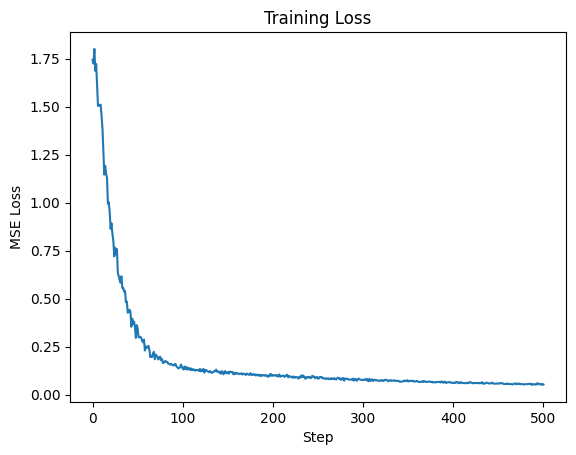

In [12]:
# --- Plotting Results ---
plt.figure()
plt.title("Training Loss")
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("MSE Loss")

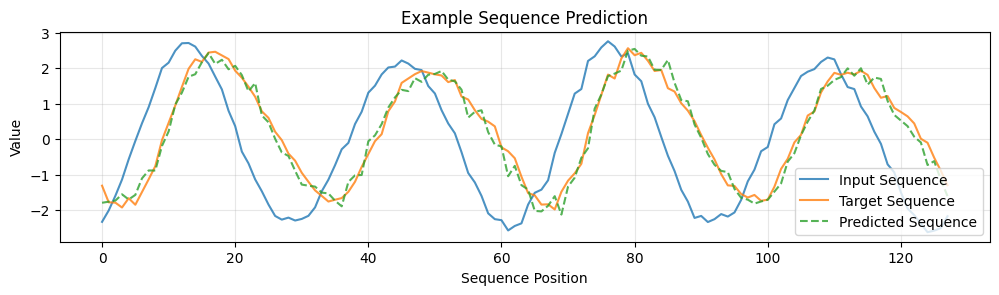

In [13]:
x_test, y_test = next(dataset(1, 1))
y_pred = model(x_test)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x_test[0], label='Input Sequence', alpha=0.8)
plt.plot(y_test[0], label='Target Sequence', alpha=0.8)
plt.plot(y_pred[0], label='Predicted Sequence', linestyle='--', alpha=0.8)
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.title('Example Sequence Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

## 3. Transformer Scaling with Tensor Parallelism

![Megatraon-LM](https://docs.pytorch.org/tutorials/_images/megatron_lm.png)

<sup> Image Source: [Megatron-LM](https://arxiv.org/abs/1909.08053) </sup>

## 4. Scaling Transformers in Flax

### 4.1 Setup for training a small Transformer Language Model

In [ ]:
!wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true -O TinyStories-train.txt

--2025-06-17 01:06:45--  https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.24, 18.172.134.4, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/42/7f/427f7497b6c6596c18b46d5a72e61364fcad12aa433c60a0dbd4d344477b9d81/c5cf5e22ff13614e830afbe61a99fbcbe8bcb7dd72252b989fa1117a368d401f?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27TinyStories-train.txt%3B+filename%3D%22TinyStories-train.txt%22%3B&response-content-type=text%2Fplain&Expires=1750126005&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MDEyNjAwNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy80Mi83Zi80MjdmNzQ5N2I2YzY1OTZjMThiNDZkNWE3MmU2MTM2NGZjYWQxMmFhNDMzYzYwYTBkYmQ0ZDM0NDQ3N2I5ZDgxL2M1Y2Y1ZTIyZmYxMzYxNGU4MzBhZmJlNjF

In [ ]:
from dataclasses import dataclass
import grain.python as pygrain
import pandas as pd
import tiktoken
import time

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

### 5.2 Define a 2D Mesh

In [ ]:
# Create a `Mesh` object representing TPU device arrangement.
mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ('batch', 'model'))

### 5.3 Define the Sharded Transformer in Flax

#### 5.3.1 Define Sharded Transformer Block

In [ ]:
# Define a triangular mask for causal attention with `jax.numpy.tril` and `jax.numpy.ones`.
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))

In [ ]:
class TransformerBlock(nnx.Module):
    """ A single Transformer block.

    Each Transformer block processes input sequences via self-attention and feed-forward networks.

    Args:
        embed_dim (int): Embedding dimensionality.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimensionality of the feed-forward network.
        rngs (flax.nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
        rate (float): Dropout rate. Defaults to 0.1.
    """
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, *, rngs: nnx.Rngs, rate: float = 0.1):
        # Multi-Head Attention (MHA) with `flax.nnx.MultiHeadAttention`.
        # Specifies tensor sharding (depending on the mesh configuration)
        # where we shard the weights across devices for parallel computation.
        self.mha = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                          bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                          rngs=rngs)
        # The first dropout with `flax.nnx.Dropout`.
        self.dropout1 = nnx.Dropout(rate=rate)
        # First layer normalization with `flax.nnx.LayerNorm`.
        self.layer_norm1 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P('model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                         rngs=rngs)
        # The first linear transformation for the feed-forward network with `flax.nnx.Linear`.
        self.linear1 = nnx.Linear(in_features=embed_dim,
                                  out_features=ff_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  rngs=rngs)
        # The second linear transformation for the feed-forward network with `flax.nnx.Linear`.
        self.linear2 = nnx.Linear(in_features=ff_dim,
                                  out_features=embed_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                  rngs=rngs)
        # The second dropout with `flax.nnx.Dropout`.
        self.dropout2 = nnx.Dropout(rate=rate)
        # Second layer normalization with `flax.nnx.LayerNorm`.
        self.layer_norm2 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P(None, 'model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, 'model'))),
                                         rngs=rngs)


    # Apply the Transformer block to the input sequence.
    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        _, seq_len, _ = input_shape

        # Instantiate the causal attention mask.
        mask = causal_attention_mask(seq_len)

        # Apply Multi-Head Attention with the causal attention mask.
        attention_output = self.mha(
            inputs_q=inputs,
            mask=mask,
            decode=False
        )
        # Apply the first dropout.
        attention_output = self.dropout1(attention_output, deterministic=not training)
        # Apply the first layer normalization.
        out1 = self.layer_norm1(inputs + attention_output)

        # The feed-forward network.
        # Apply the first linear transformation.
        ffn_output = self.linear1(out1)
        # Apply the ReLU activation with `flax.nnx.relu`.
        ffn_output = nnx.relu(ffn_output)
        # Apply the second linear transformation.
        ffn_output = self.linear2(ffn_output)
        # Apply the second dropout.
        ffn_output = self.dropout2(ffn_output, deterministic=not training)
        # Apply the second layer normalization and return the output of the Transformer block.
        return self.layer_norm2(out1 + ffn_output)


#### 5.3.2 Define Embeddings

In [ ]:
class TokenAndPositionEmbedding(nnx.Module):
    """ Combines token embeddings (words in an input sentence) with
    positional embeddings (the position of each word in a sentence).

    Args:
        maxlen (int): Matimum sequence length.
        vocal_size (int): Vocabulary size.
        embed_dim (int): Embedding dimensionality.
        rngs (flax.nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
    """
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, *, rngs: nnx.Rngs):
        # Initialize token embeddings (using `flax.nnx.Embed`).
        # Each unique word has an embedding vector.
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        # Initialize positional embeddings (using `flax.nnx.Embed`).
        self.pos_emb = nnx.Embed(num_embeddings=maxlen, features=embed_dim, rngs=rngs)

    # Takes a token sequence (integers) and returns the combined token and positional embeddings.
    def __call__(self, x):
        # Generate a sequence of positions for the input tokens.
        positions = jnp.arange(0, x.shape[1])[None, :]
        # Look up the positional embeddings for each position in the input sequence.
        position_embedding = self.pos_emb(positions)
        # Look up the token embeddings for each token in the input sequence.
        token_embedding = self.token_emb(x)
        # Combine token and positional embeddings.
        return token_embedding + position_embedding


#### 5.3.3 Define the Transformer Module

In [ ]:
class MiniGPT(nnx.Module):
    """ A miniGPT transformer model, inherits from `flax.nnx.Module`.

    Args:
        maxlen (int): Maximum sequence length.
        vocab_size (int): Vocabulary size.
        embed_dim (int): Embedding dimensionality.
        num_heads (int): Number of attention heads.
        feed_forward_dim (int): Dimensionality of the feed-forward network.
        num_transformer_blocks (int): Number of transformer blocks. Each block contains attention and feed-forward networks.
        rngs (nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
    """
    # Initialize miniGPT model components.
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, num_heads: int, feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs):
        # Initiliaze the `TokenAndPositionEmbedding` that combines token and positional embeddings.
        self.embedding_layer = TokenAndPositionEmbedding(
                    maxlen, vocab_size, embed_dim, rngs=rngs
                )
        # Create a list of `TransformerBlock` instances.
        # Each block processes input sequences using attention and feed-forward networks.
        self.transformer_blocks = [TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, rngs=rngs
        ) for _ in range(num_transformer_blocks)]
        # Initialize the output `flax.nnx.Linear` layer producing logits over the vocabulary for next-token prediction.
        self.output_layer = nnx.Linear(in_features=embed_dim,
                                       out_features=vocab_size,
                                       kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                       bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, 'model'))),
                                       rngs=rngs)

    def __call__(self, inputs, training: bool = False):
        # Pass the input tokens through the `embedding_layer` to get token embeddings.
        # Apply each transformer block sequentially to the embedded input, use the `training` flag for the behavior of `flax.nnx.Dropout`.
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        # Pass the output of the transformer blocks through the output layer,
        # and obtain logits for each token in the vocabulary (for next token prediction).
        outputs = self.output_layer(x)
        return outputs

    # Text generation.
    def generate_text(self, max_tokens: int, start_tokens: [int], top_k=10):
        # Sample the next token from a probability distribution based on
        # `logits` and `tok_k` (top-k) sampling strategy.
        def sample_from(logits):
            logits, indices = jax.lax.top_k(logits, k=top_k)
            # Convert logits to probabilities (using `flax.nnx.softmax`).
            logits = nnx.softmax(logits)
            return jax.random.choice(jax.random.PRNGKey(0), indices, p=logits)

        # Generate text one token at a time until the maximum token limit is reached (`maxlen`).
        def generate_step(start_tokens):
            pad_len = maxlen - len(start_tokens)
            # Index of the last token in the current sequence.
            sample_index = len(start_tokens) - 1
            # If the input is longer than `maxlen`, then truncate it.
            if pad_len < 0:
                x = jnp.array(start_tokens[:maxlen])
                sample_index = maxlen - 1
            # If the input is shorter than `maxlen`, then pad it (`pad_len`).
            elif pad_len > 0:
                x = jnp.array(start_tokens + [0] * pad_len)
            else:
                x = jnp.array(start_tokens)

            # Add a batch dimension.
            x = x[None, :]
            logits = self(x)
            next_token = sample_from(logits[0][sample_index])
            return next_token

        # Store generated tokens.
        generated = []
        # Generate tokens until the end-of-text token is encountered or the maximum token limit is reached.
        for _ in range(max_tokens):
            next_token = generate_step(start_tokens + generated)
            # Truncate whatever is after '<|endoftext|>' (stop word)
            if next_token == tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]:
              # Stop text generation if the end-of-text token is encountered.
              break
            generated.append(int(next_token))
        # Decode the generated token IDs into text.
        return tokenizer.decode(start_tokens + generated)

#### 5.3.4 Create the Model

In [ ]:
vocab_size = tokenizer.n_vocab
num_transformer_blocks = 8
maxlen = 256
embed_dim = 256
num_heads = 8
feed_forward_dim = 256
batch_size = 256
num_epochs = 1

In [ ]:
# Creates the miniGPT model with 4 transformer blocks.
def create_model(rngs):
    return MiniGPT(maxlen, vocab_size, embed_dim, num_heads, feed_forward_dim, num_transformer_blocks=4, rngs=rngs)

### 5.4 Data Loading

In [ ]:
@dataclass
class TextDataset:
    data: list
    maxlen: int

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # Use Tiktoken for tokenization
        encoding = tokenizer.encode(self.data[idx], allowed_special={'<|endoftext|>'})[:self.maxlen]  # Tokenize and truncate
        return encoding + [0] * (self.maxlen - len(encoding))  # Pad to maxlen

def load_and_preprocess_data(file_path, batch_size, maxlen):

    with open(file_path, 'r') as f:
      text = f.read()

    stories = text.split('<|endoftext|>')
    stories = [story+'<|endoftext|>' for story in stories if story.strip()]
    df = pd.DataFrame({'text': stories})
    data = df['text'].dropna().tolist()
    dataset = TextDataset(data, maxlen)

    sampler = pygrain.IndexSampler(
        len(dataset),
        shuffle=False,
        seed=42,
        shard_options=pygrain.NoSharding(),
        num_epochs=num_epochs,
    )

    dl = pygrain.DataLoader(
        data_source=dataset,
        sampler=sampler,
        operations=[pygrain.Batch(batch_size=batch_size, drop_remainder=True)],
    )

    return dl

text_dl = load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen)

### 5.5 Loss Function and Training Step

In [ ]:
# Defines the loss function using `optax.softmax_cross_entropy_with_integer_labels`.
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

# Define the training step with the `flax.nnx.jit` transformation decorator.
@nnx.jit
def train_step(model: MiniGPT, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, lables=batch[1])
    optimizer.update(grads)

### 5.6 Train the model

In [ ]:
model = create_model(rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3))
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)
rng = jax.random.PRNGKey(0)

start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:maxlen]
generated_text = model.generate_text(
    maxlen, start_tokens
)
print(f"Initial generated text:\n{generated_text}\n")


metrics_history = {
  'train_loss': [],
}

prep_target_batch = jax.vmap(lambda tokens: jnp.concatenate((tokens[1:], jnp.array([0]))))

step = 0
for epoch in range(num_epochs):
    start_time = time.time()
    for batch in text_dl:
        if len(batch) % len(jax.devices()) != 0:
          continue  # skip the remaining elements
        input_batch = jnp.array(jnp.array(batch).T)
        target_batch = prep_target_batch(input_batch)
        train_step(model, optimizer, metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P('batch', None))))

        if (step + 1) % 200 == 0:
          for metric, value in metrics.compute().items():
              metrics_history[f'train_{metric}'].append(value)
          metrics.reset()

          elapsed_time = time.time() - start_time
          print(f"Step {step + 1}, Loss: {metrics_history['train_loss'][-1]}, Elapsed Time: {elapsed_time:.2f} seconds")
          start_time = time.time()

          generated_text = model.generate_text(
              maxlen, start_tokens
          )
          print(f"Generated text:\n{generated_text}\n")
        step += 1

# Final text generation
generated_text = model.generate_text(
    maxlen, start_tokens
)
print(f"Final generated text:\n{generated_text}")

**LLM Output**

```
Initial generated text:
Once upon a timeaciaGender gearuser Analysisval {} Bruce Lauren helic Lauren Bruce againstliterally SQU retire Path {}valascript northwest {} Bruceuit Pathascript northwestdrops freelyvic996 curated hysteria survivor {}sclaxteradvert Sitting qualifiers snack {} scenariovalameron {} Path {}Nick VeganExcept peasantascript Whites retire {} retire {} Analysisrest {} Mine psychedelic flankForgeModLoader Path Bravo {} inflic {} strutConnector psychedelic beyond Beforeocker interesting Dani {}sclaxter retire {}Nick sorrow Typesrest interestingUV FSyrus resorts {} Dani {} perished {} retire interesting sorrow reversibleurned {} Womanlast 118 reass gentlestudyManager {} retire {} verb Captain forbid Bruce {} Analysis ox {} inexplicable tumor psychedelic {} serverpel perished Tang {} cropDisclaimeruti nond {} scenario teach serverlast {} Woman {}absor northwestroid variable {} Whites {} dancers iPod {} {}valolate Assist hiding ox {}ampionscre lineman servesShould decision psychedelicShould beyondwaves {} retire interesting Tangresterv ribbon complicationsaggressiverest {} SessionSmith {}Nick abnorm dissatisfiedundrum {} perished {} Gustav rolled shamefulundrum retire {}valundrumlast {}val {} perished Brigham Analysis developerscre Atom {}scl HouthInteger {} northwest appease miles {} perished THR Hyundai Captainケ {} Cube psychedelic {} inflic {} retire {} Whites dancers {}scl FS lore appease Din {} Whites abnorm[] {} {}scl FS appease dangling Bruce abnormcre97 psychedeliccrecrecrecre

Step 200, Loss: 4.653054714202881, Elapsed Time: 108.56 seconds
Generated text:
Once upon a time, there a little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little little!!!!


Final generated text:
Once upon a time, there was a little girl named Lucy. She was very excited to go to the park. She put on her shoes and ran to the park.
When she got to the park, she saw a big slide. She wanted to go on it. She ran to the slide and started to slide down. She was so fast!
Suddenly, she heard a loud noise. It was a big, scary dog. The dog was barking loudly. Lucy was scared. She ran back to the park and started to run.
The dog was so fast that it ran away. Lucy was safe. She was so happy she had gone on the slide.
```

#### 5.7 Inspect Training Curve and Save Checkpoint

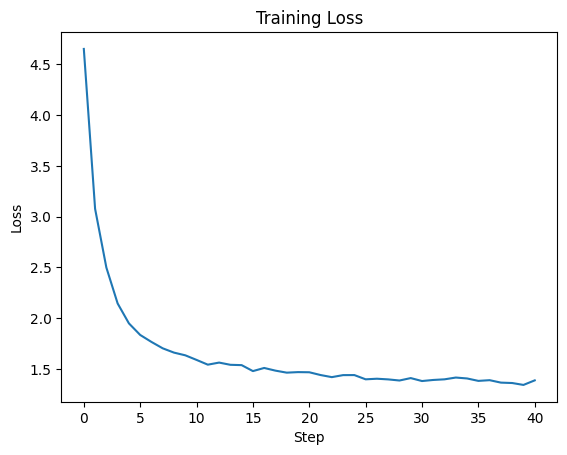

In [ ]:
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [ ]:
import orbax.checkpoint as orbax

state = nnx.state(model)

checkpointer = orbax.PyTreeCheckpointer()
checkpointer.save('/content/save', state)

# Make sure the files are there
!ls /content/save/

array_metadatas       d		      _METADATA        _sharding
_CHECKPOINT_METADATA  manifest.ocdbt  ocdbt.process_0
